In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd
from tqdm.auto import notebook_tqdm as tqdm
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel

%load_ext autoreload
%autoreload 2

import tetrahedron
import proj_quality
from metric.metric import Metric, Euclid 

In [173]:
# simulate triangles
rng = np.random.default_rng()
metric = Euclid(2)

def generate_univar_points(n_samples = 1000, dim = 7):  
    points = rng.random(size=[n_samples, dim]) * 37 - 37/2
    return points

def generate_univar_grid_points(n_samples = 1000, dim = 7):  
    points = rng.integers(low=37//2, high=37*2, size=[n_samples, dim])
    return points

def generate_gaussian_points(n_samples = 1000, dim = 7, homogenious=False):  
    points = rng.standard_normal([n_samples, dim])
    if homogenious:
        scale = np.array([1]*dim)
    else:
        scale = 1 + 10* rng.random(size=dim)
    points *= scale[np.newaxis,:]
    return points

def generate_multi_cluster(n_samples=1000, dim=7):
    std=3 # good overlap, but still differentiable
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std)
    return points

def generate_sparse_cluster(n_samples=1000, dim=7):
    std = 1 # almost no overlap
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std)
    return points

In [158]:
def max_dist_points(ps):
    dists = spatial.distance_matrix(ps,ps)
    flat_index = dists.argmax()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

In [159]:
def min_dist_points(ps):
    dists = spatial.distance_matrix(ps,ps)
    diag = np.diag_indices(len(ps))
    dists[diag] = np.inf
    
    flat_index = dists.argmin()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

In [107]:
def mask_diag(a):
    diag = np.diag(np.ones(a.shape[0]))
    return np.ma.array(a, mask=diag)

In [234]:
def get_most_central_points_idx(ps):
    dists = spatial.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    
    return np.argsort(dists.std(axis=1))

def two_most_central(ps):
    cent = get_most_central_points_idx(ps)
    return ps[cent[:2]]

def two_least_central(ps):
    cent = get_most_central_points_idx(ps)
    return ps[cent[-2:]]

def two_remote_points(ps):
    dists = spatial.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    remoteness = (dists**2).sum(axis=1)
    remoteness_idx = np.argsort(remoteness)
    return ps[remoteness_idx[-2:]]

def central_and_distant(ps):
    cent = get_most_central_points_idx(ps)
    p0 = ps[cent[0]]
    most_dist = np.argmax(metric(p0, ps))
    p1 = ps[most_dist]
    return p0, p1

In [212]:
def find_close_center(ps, cluster_member):
    dists = metric(cluster_member, ps)
    invalid_mask = ~np.isfinite(dists) | np.iscomplex(dists)
    dists = dists[invalid_mask]
    close_points = ps[dists < np.nanmedian(dists)]
    
    dists = metric.distance_matrix(close_points, close_points)
    dists = mask_diag(dists)
    
    center_idx = np.argmin(dists.std(axis=1))
    return close_points[center_idx]

def different_cluster_centers(ps):
    # a,b are likely in different clusters
    a, b = max_dist_points(ps)
    center_a = find_close_center(ps, a)
    center_b = find_close_center(ps, b)
    return center_a, center_b
    

In [195]:


def optimize_pivots(points, criterion, return_full=False):
    quality = np.nan * np.ones([len(points), len(points)],float)

    for i, p0 in enumerate(tqdm(points)):
        for j, p1 in enumerate(tqdm(points, leave=False)):
            if j<=i: continue
            try:
                points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                quality[i,j] = criterion(points_p)
            except KeyError:
                quality[i,j] = np.nan

    
    # make symmetric
    lower_tri = np.tril_indices(quality.shape[0], -1)
    quality[lower_tri] = quality.T[lower_tri]
    
    quality = mask_diag(quality)
    
    if return_full:    
        return quality
    else:
        return np.unravel_index(np.argmax(quality), quality.shape)

In [11]:
def _hilbert_quality(points, r):
    try:
        part = proj_quality.HilbertPartitioner(points, r)
        return part.hyperplane_quality(points)
    except KeyError:
        raise
        return 0

In [19]:
index = optimize_pivots(points, _hilbert_quality, False)
p0,p1 = points[np.array(index)]
points_p_best_hq = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [196]:
def compare_projections(point_gen, pivot_selector:dict, samples=5, aggregate=False):
    rv = []
    for run in tqdm(range(samples), leave=False):
        points = point_gen()
        r = proj_quality.get_average_k_nn_dist(points, metric, k=10)
        for name, select_pivots in pivot_selector.items():
            p0, p1 = select_pivots(points)
            points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
            rv.append(dict(
                run=run,
                algorithm=name,
                mean_candidate_set_size=proj_quality.candidate_set_size(points_p,r,metric),
                hilbert_quality=_hilbert_quality(points_p,r)
            
            ))
    rv = pd.DataFrame(rv)
    
    if aggregate:
        def to_ufloat(data):
            return ufloat(np.mean(data), np.std(data,ddof=1))
        rv = rv.drop(columns="run").groupby("algorithm").agg(to_ufloat)
    return rv

In [238]:
algs = dict(
    random=lambda points:rng.choice(points, size=2, replace=False),
    maximize_dist=max_dist_points,
    #minimize_dist=min_dist_points,
    #central_points=two_most_central,
    non_central_points=two_least_central,
    remoteness=two_remote_points,
    #central_and_distant=central_and_distant,
    
    #different_cluster_centers=different_cluster_centers
)

In [246]:
def run(dim):
    #gen = lambda:generate_gaussian_points(dim=dim, homogenious=True)
    gen = lambda:generate_points(dim=dim)

    r = compare_projections(
        gen, algs, samples=100, aggregate=False
    )
    r["dim"] = dim
    return r

jobs = [delayed(run)(dim) for dim in range(2,15)]
results = pd.concat(Parallel(n_jobs=22)(jobs))

In [247]:
def _normalize(df):
    df.hilbert_quality /= df.hilbert_quality.mean()
    df.mean_candidate_set_size /= df.mean_candidate_set_size.mean()
    return df
normalized_res = results.groupby("dim").apply(_normalize)

/tmp/ipykernel_144536/145316497.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_res = results.groupby("dim").apply(_normalize)


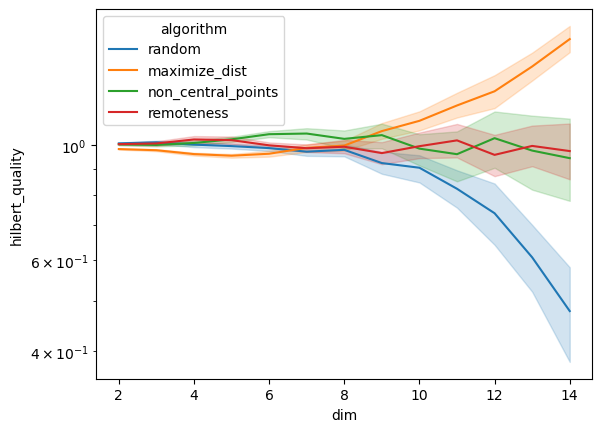

In [248]:
sns.lineplot(normalized_res, x="dim", y="hilbert_quality", hue="algorithm")
plt.yscale("log")

(0.9, 1.1)

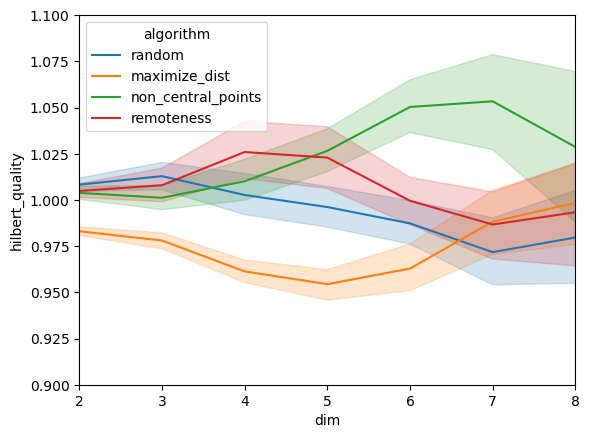

In [249]:
sns.lineplot(normalized_res, x="dim", y="hilbert_quality", hue="algorithm")
plt.xlim(2,8)
plt.ylim(0.9,1.1)

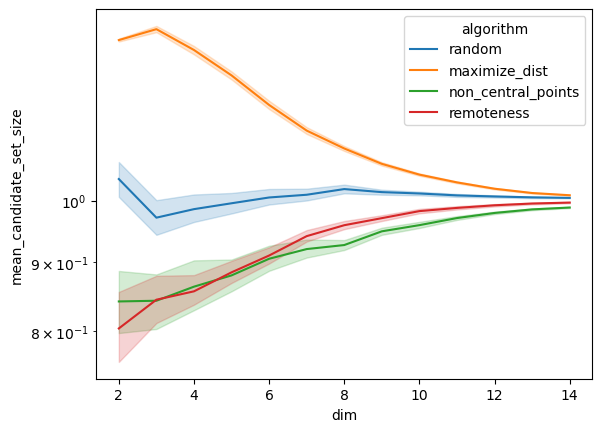

In [250]:
sns.lineplot(normalized_res, x="dim", y="mean_candidate_set_size", hue="algorithm")
plt.yscale("log")

<Axes: xlabel='dim', ylabel='mean_candidate_set_size'>

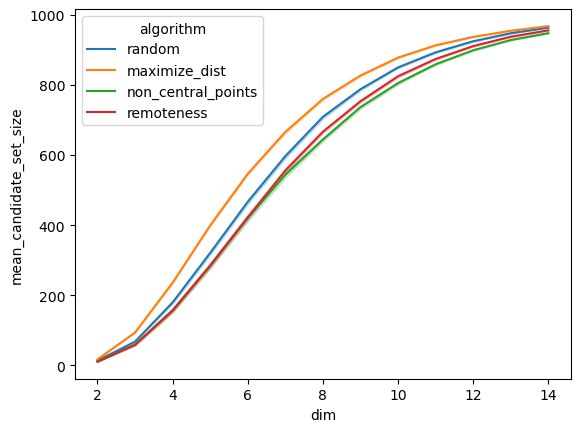

In [251]:
sns.lineplot(results, x="dim", y="mean_candidate_set_size", hue="algorithm")
#plt.yscale("log")

<Axes: xlabel='dim', ylabel='hilbert_quality'>

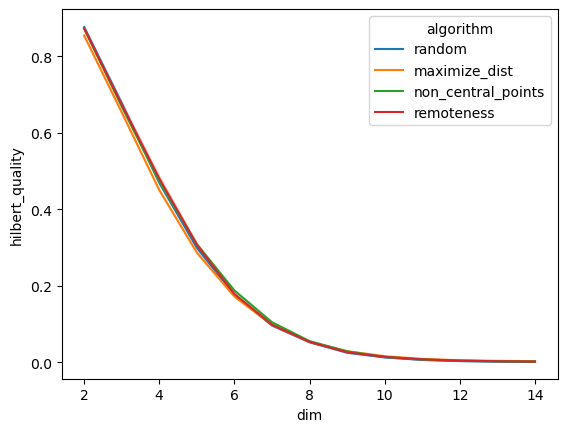

  0%|          | 0/100 [00:00<?, ?it/s]


In [252]:
sns.lineplot(results, x="dim", y="hilbert_quality", hue="algorithm")
#plt.yscale("log")

In [48]:
def plot_hilbert_qual(ps):
    part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
    l, r = part.get_partitions(ps)

    plt.scatter(*ps.T)
    plt.scatter(*ps[l].T, marker="+", label="left partition")
    plt.scatter(*ps[r].T, marker="x", label="right partition")
    
    hq = part.hyperplane_quality(ps)
    css = proj_quality.candidate_set_size(ps,ten_nn_dist, Euclid(2))
    plt.title(f"partitioning {hq:.0%} points\nmean CSS {css:.0f}")
    plt.legend()
    plt.tight_layout()

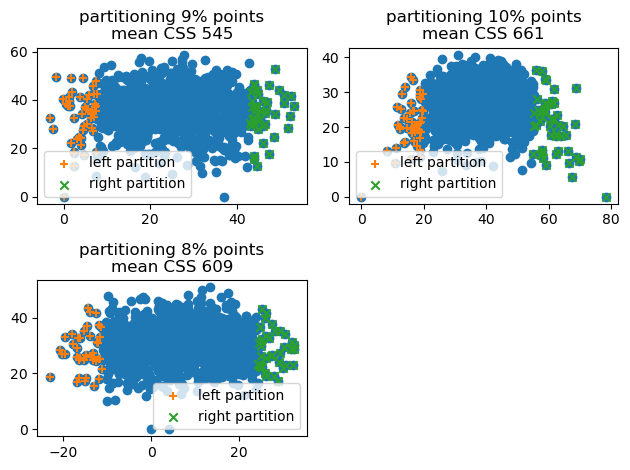

In [53]:
plt.subplot(2,2,1)
plot_hilbert_qual(points_p)
plt.subplot(2,2,2)
plot_hilbert_qual(points_p_max_dist)
plt.subplot(2,2,3)
plot_hilbert_qual(points_p_min_dist)